In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm 
import numpy as np

print("CUDA:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA: False


In [3]:
def fibre_propagation(U0, wvl, x, z, refractive_index):
    nx = U0.shape[0]
    k = 2 * torch.pi / wvl

    dx = torch.abs(x[1] - x[0])
    fx = torch.fft.fftfreq(nx, dx, device=U0.device)

    U_out = torch.zeros(nx, z.shape[0], device=U0.device) + 0j
    U_out[:, 0] = U0 

    absorbing_window = torch.exp(-(x / (40e-6))**20)
    dz = z[1] - z[0]
    
    H = torch.exp(1j * k * dz * torch.sqrt(1 + 0j - (wvl * fx) ** 2))
    for i in range(1, z.shape[0]):
        U_in = U_out[:, i - 1]
        phase_shift = torch.exp(1j * k * dz * refractive_index[:, i - 1]) * absorbing_window
        U1 = torch.fft.fftshift(torch.fft.ifft(torch.fft.fft(torch.fft.ifftshift(U_out[:, i - 1] * phase_shift)) * H))
        U_out[:, i] = U1
        

    return U_out

Text(0, 0.5, 'x in m')

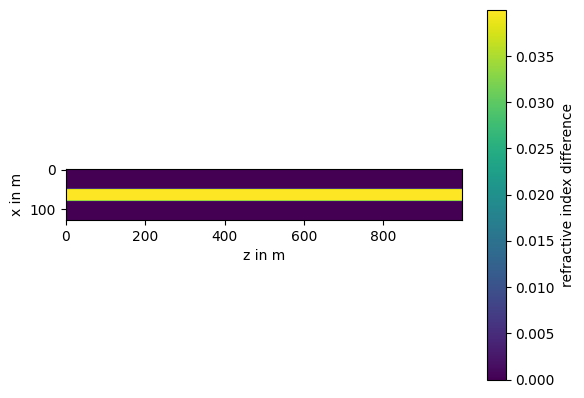

In [4]:
refractive_index = torch.zeros(128, 1000)
wvl = 633e-9

x = torch.linspace(-50e-6, 50e-6, 128)
z = torch.linspace(0e-6, 500e-6, 200)
refractive_index[50:80, :] = 0.04

plt.imshow(refractive_index.cpu().numpy())
plt.colorbar(label="refractive index difference")
plt.xlabel("z in m")
plt.ylabel("x in m")

Text(0, 0.5, 'x in m')

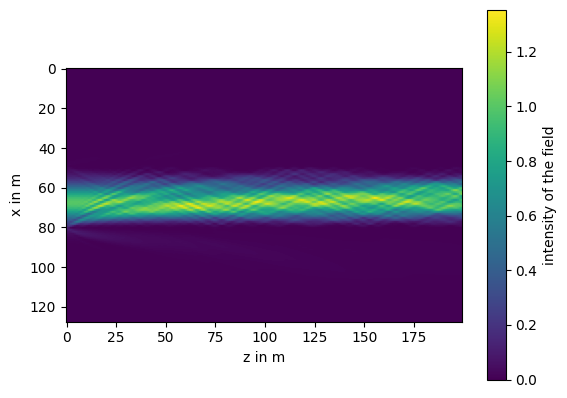

In [5]:
U0 = torch.exp(-(x-3e-6)**2 / (2 * 5e-6)**2)
U_prop = fibre_propagation(U0, wvl, x, z, refractive_index)

plt.imshow((torch.abs(U_prop)**2).cpu().numpy())
plt.colorbar(label="intensity of the field")
plt.xlabel("z in m")
plt.ylabel("x in m")

# Focusing through Fiber

In this section, you will measure a transmission matrix. To do so, launch single 1D peaks into the fiber and record the output field at the end of the fibre. 

For the inversion of `M`, use `torch.pinverse(M, rcond=1e-2)`.

Determine a complex input field that, when launched through the fiber, produces a single peak at the x-location `x=5.12µm`.
The entire spatial domain is in 1D.

Verify that your calculated field focuses roughly to one spot by sending it through the fibre again.

In [6]:
def build_transmission_matrix(fibre_fn, x, z, wvl, refractive_index):
    N = x.shape[0]
    M = torch.zeros(N, N, dtype=torch.cfloat)

    for i in tqdm.trange(N):
        # Input: narrow peak at position i
        U0 = torch.zeros_like(x, dtype=torch.cfloat)
        U0[i] = 1.0 + 0j
        
        # Propagate
        U_out = fibre_fn(U0, wvl, x, z, refractive_index)
        
        # Save output field at final z-position
        M[:, i] = U_out[:, -1]

    return M

M = build_transmission_matrix(fibre_propagation, x, z, wvl, refractive_index)


100%|██████████| 128/128 [00:01<00:00, 65.11it/s]


In [7]:
# Find the index closest to 5.12 µm
target_x = 5.12e-6
target_idx = torch.argmin(torch.abs(x - target_x))


desired_output = torch.zeros(x.shape[0], dtype=torch.cfloat)
desired_output[target_idx] = 1.0 + 0j


input_field = torch.pinverse(M, rcond=1e-2) @ desired_output


Text(0.5, 1.0, 'Focused Output Field')

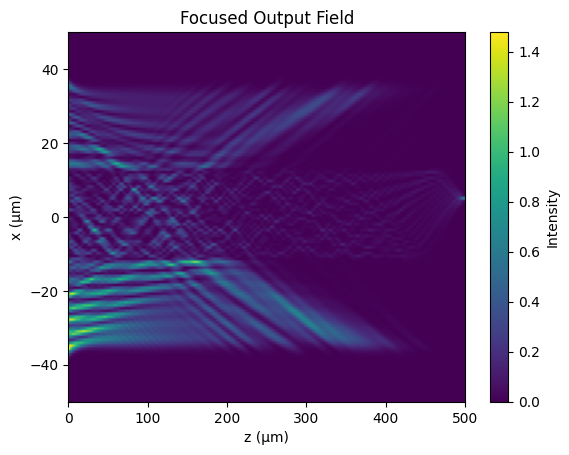

In [8]:
U_prop = fibre_propagation(input_field, wvl, x, z, refractive_index)

plt.imshow((torch.abs(U_prop)**2).cpu().numpy(), aspect='auto',
           extent=[z[0]*1e6, z[-1]*1e6, x[0]*1e6, x[-1]*1e6],
           origin='lower')
# reverse the y-axis to to match the input field

plt.colorbar(label="Intensity")
plt.xlabel("z (µm)")
plt.ylabel("x (µm)")
plt.title("Focused Output Field")


/Users/kilianpouderoux/opt/anaconda3/envs/fastreid/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


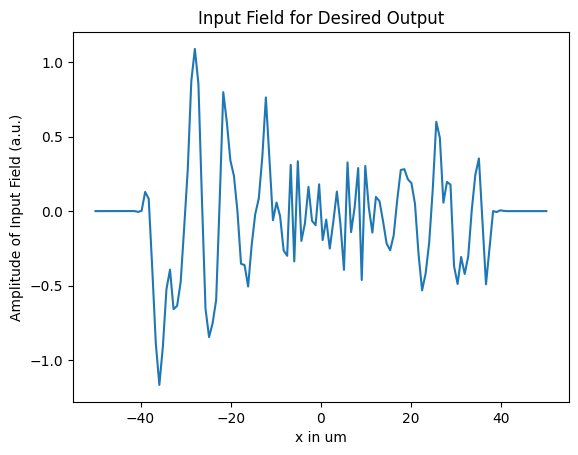

In [9]:
plt.plot(x.cpu().numpy()*1e6, input_field.cpu().numpy())
plt.xlabel("x in um")
plt.ylabel("Amplitude of Input Field (a.u.)")
plt.title("Input Field for Desired Output")
plt.show()

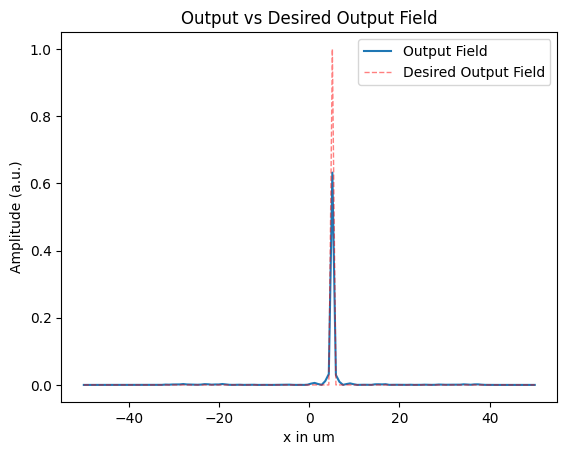

In [ ]:
plt.plot(x.cpu().numpy()*1e6 , U_prop[:, -1].cpu().numpy(), label="Output Field")
plt.plot(x.cpu().numpy()*1e6, desired_output.cpu().numpy(), label="Desired Output Field", linestyle='--', color='red', alpha=0.5, linewidth=1)   
plt.xlabel("x in um")
plt.ylabel("Amplitude (a.u.)")
plt.title("Output vs Desired Output Field")
plt.legend()
plt.show()